# Setup (on collab)

In [37]:
# Executa apenas se estiver rodando no Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/alicebarbosam/fraud-detection-kaggle.git
    %cd fraud-detection-kaggle
    !pip install -r requirements-colab.txt

# Inference

In [ ]:
import os
import joblib
import pandas as pd
import shap

model = joblib.load("../models/xgb_optuna_final.joblib")

test_df = pd.read_csv("../data/test.csv")

X_test = test_df.drop(columns=["id"])
test_ids = test_df["id"]

test_probs = model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "id": test_ids,
    "target": test_probs
})

os.makedirs("../outputs", exist_ok=True)
submission.to_csv("../outputs/submission.csv", index=False)

print("Saved: ../outputs/submission.csv")
print(submission.head())

Saved: ../outputs/submission.csv
       id    target
0  263021  0.000147
1   11379  0.000130
2  147284  0.002449
3  219440  0.000074
4   36940  0.010155


In [31]:
print(submission["target"].describe())
print("max:", submission["target"].max())
print("min:", submission["target"].min())
print("count > 0.5:", (submission["target"] > 0.5).sum())
print("count > 0.1:", (submission["target"] > 0.1).sum())
print("count > 0.01:", (submission["target"] > 0.01).sum())

count    56962.000000
mean         0.004060
std          0.046673
min          0.000032
25%          0.000174
50%          0.000318
75%          0.000762
max          0.999825
Name: target, dtype: float64
max: 0.9998246
min: 3.167736e-05
count > 0.5: 132
count > 0.1: 286
count > 0.01: 1678


# XAI

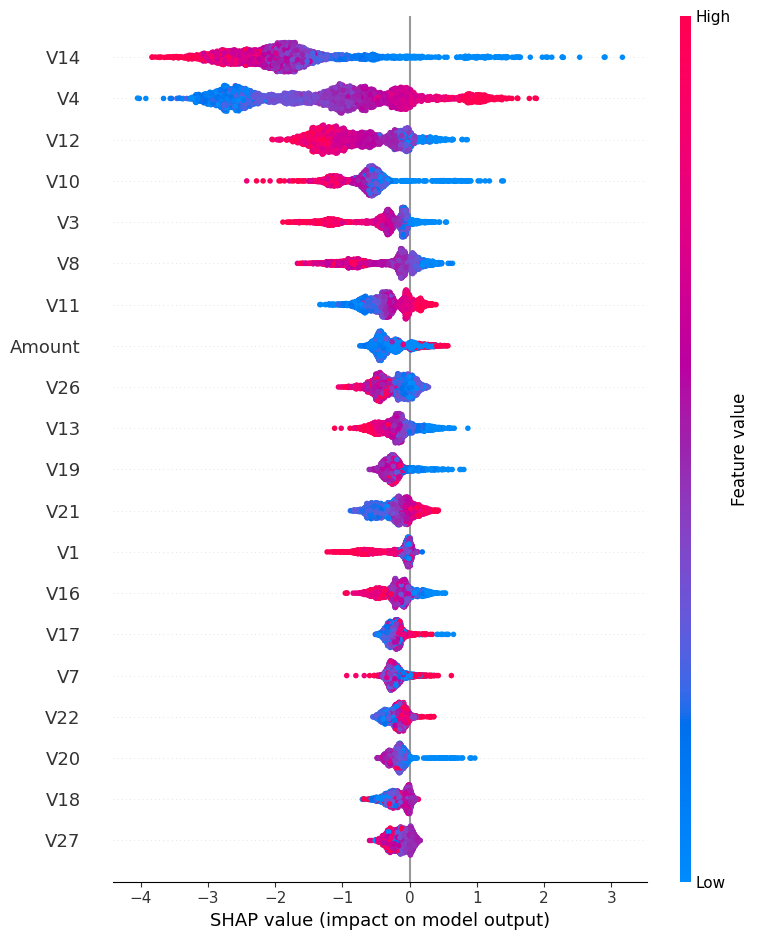

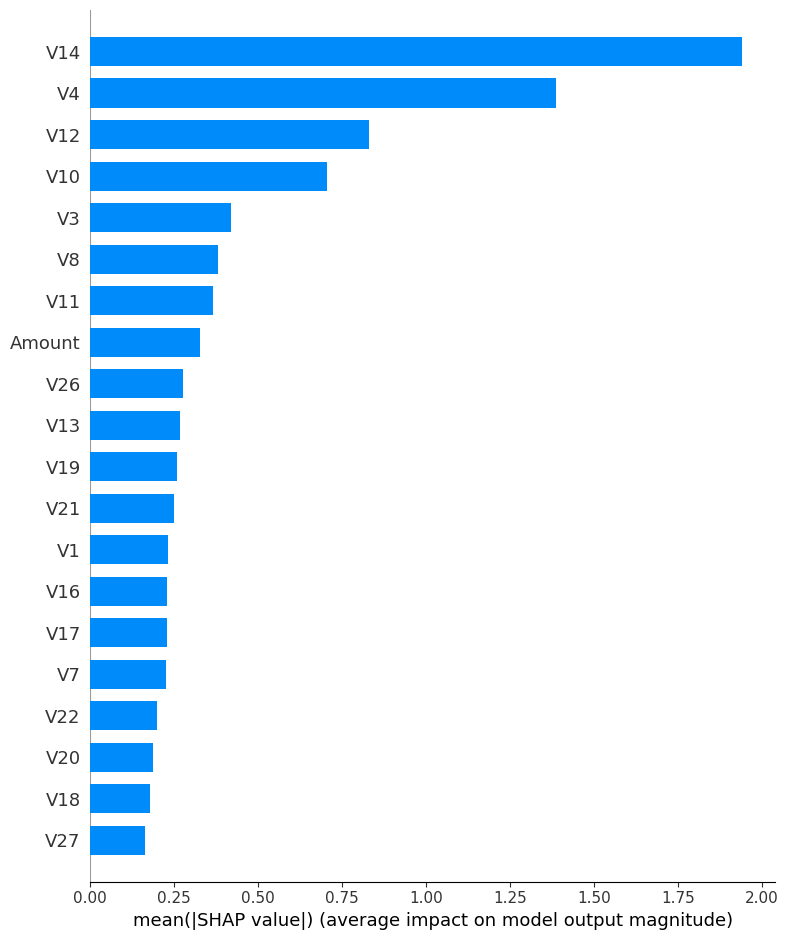

Top SHAP feature: V14


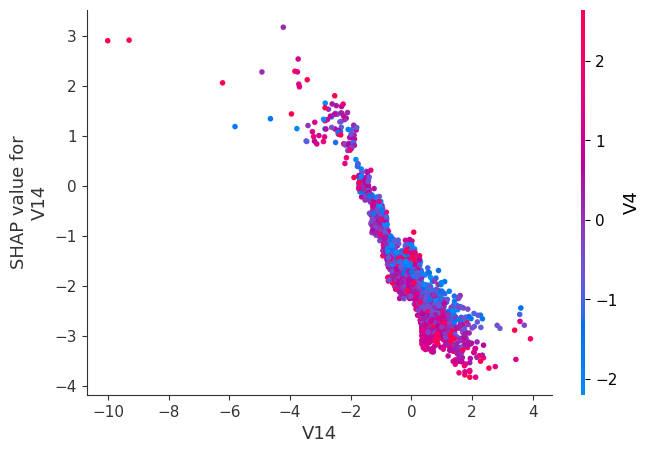

In [ ]:


# sample pra não explodir tempo/memória
SAMPLE_SIZE = 3000
X_sample = X_test.sample(SAMPLE_SIZE, random_state=42)

explainer = shap.TreeExplainer(model)



# Global importance
shap.summary_plot(shap_values, X_sample, show=True)
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_feature = X_sample.columns[np.argmax(mean_abs_shap)]
print("Top SHAP feature:", top_feature)

shap.dependence_plot(top_feature, shap_values, X_sample, show=True)

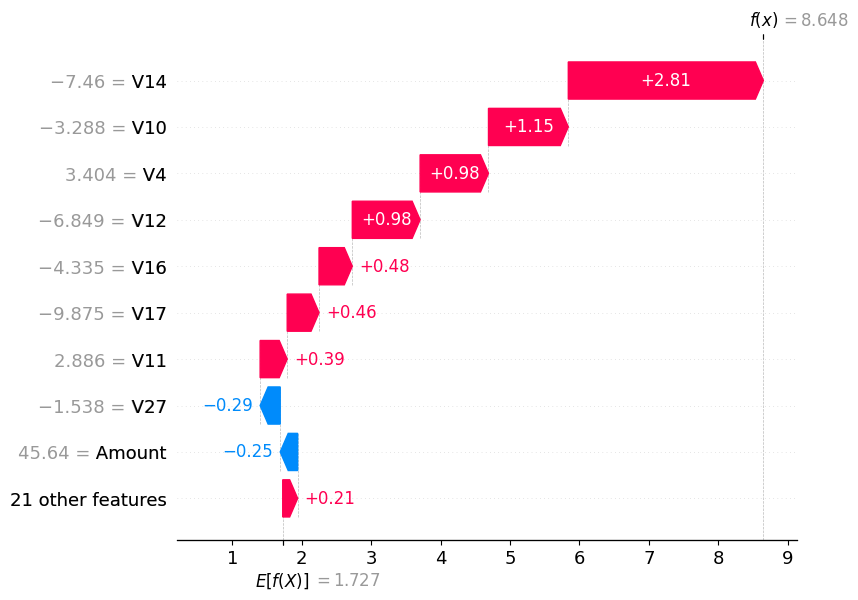

In [ ]:
top_idx = submission["target"].nlargest(5).index
X_top = X_test.loc[top_idx]

try:
    shap_top = explainer.shap_values(X_top)
    i = 0
    shap.plots.waterfall(shap.Explanation(values=shap_top[i],
                                          base_values=explainer.expected_value,
                                          data=X_top.iloc[i],
                                          feature_names=X_top.columns))
except Exception:
    exp = explainer(X_top)  
    shap.plots.waterfall(exp[0])